# Train MNIST Dataset Using CNN

**Classifier** is consist of
- 2 Convolution Layer
- 2 Fully Connected Layer
- Log SoftMax Output

**NLL Loss Function**

**Adam Optimizer**

**Many of codes here are taken from below and modified**
> https://github.com/udacity/deep-learning-v2-pytorch/tree/master/convolutional-neural-networks/mnist-mlp

# Load Data

In [1]:
# import libraries
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler # for validation

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=train_transforms)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers) # for validation: sampler = train_sampler
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers) # for validation: sampler = train_sampler
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# Visualize a batch

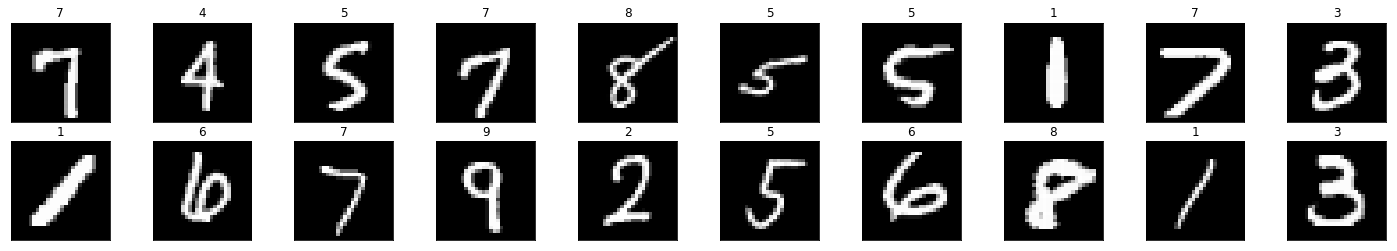

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

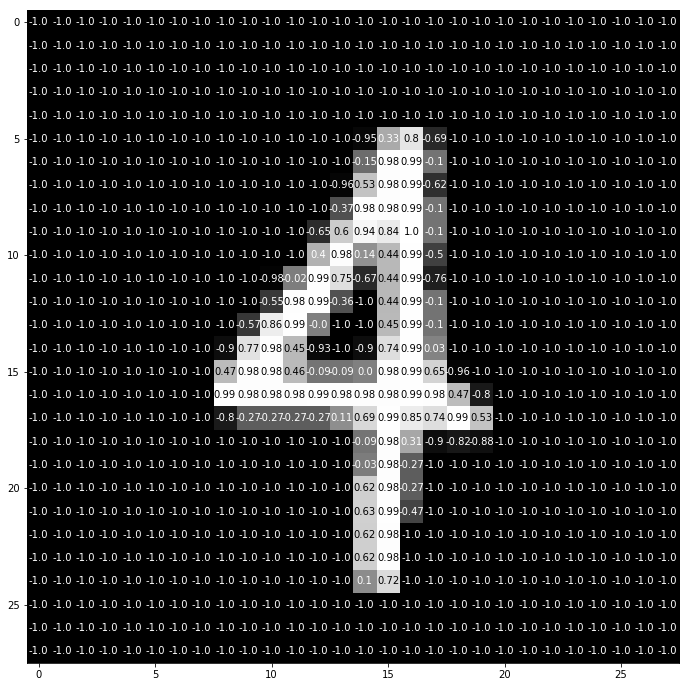

In [3]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# Define Classifier

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
       # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        # convolutional layer (sees 14x14x4 tensor after MaxPool)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (7 * 7 * 16)
        self.fc1 = nn.Linear(7 * 7 * 16, 512)
        # linear layer (512 -> 10)
        self.fc2 = nn.Linear(512, 10)
        # dropout layer (p=0.20)
        self.dropout = nn.Dropout(0.20)
        
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten image input
        x = x.view(-1, 7 * 7 * 16)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        # LogSoftMax
        return F.log_softmax(x, dim=1)
        
# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


# Set Loss Function and Optimizer

In [5]:
from torch import optim

# Loss Function and Optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Set Cuda

In [6]:
# move tensors to GPU if CUDA is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

# Train

In [8]:
epochs = 5
steps = 0
valid_loss_min = np.Inf # track change in validation loss

train_losses, test_losses = [], []
for epoch in range(epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    
    for images, labels in train_loader:
        
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
            
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, labels)
            # update average validation loss 
            valid_loss += loss.item()
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss        
        


Epoch: 0 	Training Loss: 0.007150 	Validation Loss: 0.004005
Validation loss decreased (inf --> 0.004005).  Saving model ...
Epoch: 1 	Training Loss: 0.004595 	Validation Loss: 0.002991
Validation loss decreased (0.004005 --> 0.002991).  Saving model ...
Epoch: 2 	Training Loss: 0.003939 	Validation Loss: 0.002648
Validation loss decreased (0.002991 --> 0.002648).  Saving model ...
Epoch: 3 	Training Loss: 0.003619 	Validation Loss: 0.003225
Epoch: 4 	Training Loss: 0.003354 	Validation Loss: 0.003415


# Check Losses

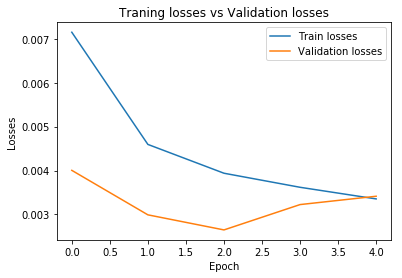

In [9]:
import matplotlib.pyplot as plt
x = range(epochs)
plt.plot(x, train_losses, label = "Train losses")
plt.plot(x, test_losses, label = "Validation losses")
plt.title("Traning losses vs Validation losses")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.legend()
plt.show()

# Load Model State

In [10]:
model.load_state_dict(torch.load('model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Test

In [11]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
classes = ["1","2","3","4","5","6","7","8","9","0"]
model.eval()
with torch.no_grad():
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      
      
      ps = torch.exp(output) # logSoftMax Ps -> Ps
      
      # convert output probabilities to predicted class
      _, pred = torch.max(ps, 1)    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.041858

Test Accuracy of     1: 99% (974/980)
Test Accuracy of     2: 99% (1129/1135)
Test Accuracy of     3: 97% (1006/1032)
Test Accuracy of     4: 99% (1003/1010)
Test Accuracy of     5: 98% (970/982)
Test Accuracy of     6: 98% (877/892)
Test Accuracy of     7: 98% (945/958)
Test Accuracy of     8: 97% (1004/1028)
Test Accuracy of     9: 98% (962/974)
Test Accuracy of     0: 97% (984/1009)

Test Accuracy (Overall): 98% (9854/10000)


# Check Test Result

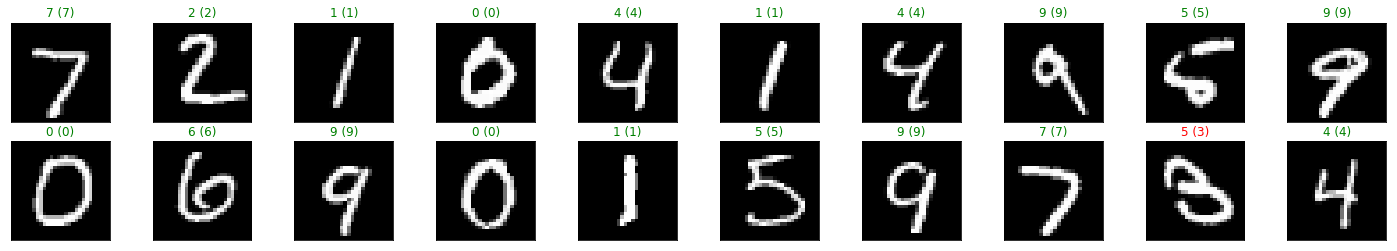

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))